In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

### 1. data preprorcessing: prepare data for training & test sets

#### import dataset and data cleaning and selection 

The training dataset includes wind speeds of various altitude increments, in 10 minutes intervals, for a little more than 12 month. It includes horizontal wind speed, vertical wind speed, mean values, max and min values in the increments, standard deviations and other columns. 

There are certain unrealistic values for wind speeds suh as 9999 or 9998 or N/A, this is likely due to processing error in the technical instrumet.

Thus, for data cleaning, we will filter out the values above 50 as it is nearly impossible for wind speed in the given altitudes to exceed 50. And for data selection, we shall only use the columns that record the horizontal wind speeds as the HAWTs (Horizontal-Axis Wind Turbines) use the lift force of the horizontal winds to generate energy, and disregard the other data for now.  

In [2]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2022-01-29 00:00:00,10.4512,0.9643,13.4083,8.677,43.9618,0.2045,4,0,32,...,5.316,-7.165,5.282,-7.98,6.971,-6.687,12.97,39.4847,-73.5908,E05
1,2022-01-29 00:10:00,11.0738,0.8861,13.0669,9.1183,43.9564,0.3611,4,0,32,...,5.145,-6.437,5.686,-8.02,8.3,-7.213,12.97,39.4847,-73.5908,E05
2,2022-01-29 00:20:00,11.1295,1.0978,13.8472,8.8772,44.2444,0.2759,4,0,32,...,6.586,-8.72,6.736,-9.23,8.15,-8.99,12.97,39.4847,-73.5909,E05
3,2022-01-29 00:30:00,11.0591,1.0196,13.7819,9.2176,46.5821,0.1763,4,0,33,...,6.492,-7.805,8.22,-8.76,6.353,-8.91,12.97,39.4847,-73.5909,E05
4,2022-01-29 00:40:00,11.1425,0.8374,13.1432,9.2309,49.2058,0.3055,6,0,33,...,6.116,-7.546,6.578,-8.84,8.57,-10.83,12.97,39.4847,-73.5909,E05


In [3]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar138m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar138m_Z10_HorizWS
0,11.5242
1,11.9534
2,11.9038
3,12.4251
4,12.3536


#### Data normalization

The data is normalized with MinMax (imported from the scikit-learn library) for MinMax scaling's ability to transform data into a bounded range while preserving temporal relationships. It is suitable for TimeGAN models like this one, which are designed to generate realistic time-series data.

In [4]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar138m_Z10_HorizWS
0,0.325370
1,0.337943
2,0.336490
3,0.351761
4,0.349666


#### Reshaping the data

LSTM model is chosen to focus on seasonal variations so the previos

In [5]:
# Function to convert the dataset into a supervised learning problem
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(X.iloc[i + time_steps])  # Target value to predict
    return np.array(Xs), np.array(ys)

# Choosing a time step for LSTM
time_steps = 144  # Represents how many time steps back the network will learn

# Structuring the data for LSTM
X, y = create_dataset(normalized_df, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Displaying the shape of the structured data
X_train.shape, X_test.shape

((9682, 144, 1), (38728, 144, 1))

#### Defining the LSTM model

In [6]:
#n_neurons = 64
#activation = "relu"
#num_epochs = 100
#learning_rate = 0.001
#minibatch_size = 64

In [7]:
#model = Sequential([
#    LSTM(n_neurons, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = activation),
#    Dropout(0.2),
#    LSTM(n_neurons, return_sequences = False, activation = activation),
#    Dropout(0.2),
#    Dense(1, activation = activation)
#])
#
##model.compile(optimizer = 'adam', loss = 'mse')
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = 'mse')
#
#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights = True)

In [8]:
#history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = minibatch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

#### Keras Tuner

In [9]:
num_epochs = 50
minibatch_size = 64
n_trials = 10
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights = True)

In [10]:
def build_model(hp):

    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'LOG')
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    model = keras.Sequential()
    
    model.add(LSTM(
        hp.Int('neurons', min_value = 32, max_value = 512, step = 32),
        input_shape = (X_train.shape[1], X_train.shape[2]),
        return_sequences = True,
        activation = hp_activation
    ))

    model.add(Dropout(rate = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(LSTM(
        hp.Int('neurons', min_value = 32, max_value = 512, step = 32),
        return_sequences = False,
        activation = hp_activation
    ))

    model.add(Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.5, step = 0.1)))

    model.add(Dense(1, activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))

    model.compile(loss = hp_loss, optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate))

    #model.compile(
    #    optimizer=keras.optimizers.Adam(
    #        hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'LOG')
    #    ),
    #    loss = 'mean_squared_error'
    #)
    return model

In [11]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = n_trials,  # Number of trials
    executions_per_trial = 1,
    directory = 'my_dir',
    project_name = 'lstm_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}
neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [12]:
tuner.search(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
0.0047068         |0.0047068         |learning_rate
mae               |mae               |loss
320               |320               |neurons
0                 |0                 |dropout_1
0.4               |0.4               |dropout_2

Epoch 1/50
303/303 [==============================] - 680s 2s/step - loss: 0.0379 - val_loss: 0.0230
Epoch 2/50
303/303 [==============================] - 628s 2s/step - loss: 0.0262 - val_loss: 0.0157
Epoch 3/50
303/303 [==============================] - 614s 2s/step - loss: 0.0241 - val_loss: 0.0141
Epoch 4/50
303/303 [==============================] - 603s 2s/step - loss: 0.0229 - val_loss: 0.0127
Epoch 5/50
303/303 [==============================] - 618s 2s/step - loss: 0.0235 - val_loss: 0.0142
Epoch 6/50
303/303 [==============================] - 621s 2s/step - loss: 0.0224 - val_loss: 0.0205
Epoch 7/50
303/303 [=======

KeyboardInterrupt: 

In [13]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.summary()
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 320)          412160    
                                                                 
 dropout (Dropout)           (None, 144, 320)          0         
                                                                 
 lstm_1 (LSTM)               (None, 320)               820480    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense (Dense)               (None, 1)                 321       
                                                                 
Total params: 1232961 (4.70 MB)
Trainable params: 1232961 (4.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
{'activation': 're

In [14]:
model_best = tuner.hypermodel.build(best_hyperparameters)

history_best = model_best.fit(X_train, y_train,
                              #batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

Epoch 1/50
108/243 [============>.................] - ETA: 1:53 - loss: nan

KeyboardInterrupt: 

In [ ]:
def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)
best_model.save(os.path.join(model_path, 'LSTM_model.h5'))
model_path = os.path.join(os.getcwd(), 'saved_model', 'LSTM_model.h5')
lstm_model = load_model(model_path)

c:\Users\Jiarong Xie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_path = os.path.join(os.getcwd(), 'saved_model', 'LSTM_model.h5')
lstm_model = load_model(model_path)

In [ ]:
test_mse = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_mse}")

KeyboardInterrupt: 

In [ ]:
y_pred = lstm_model.predict(X_test)

1214/1214 [==============================] - 50s 41ms/step


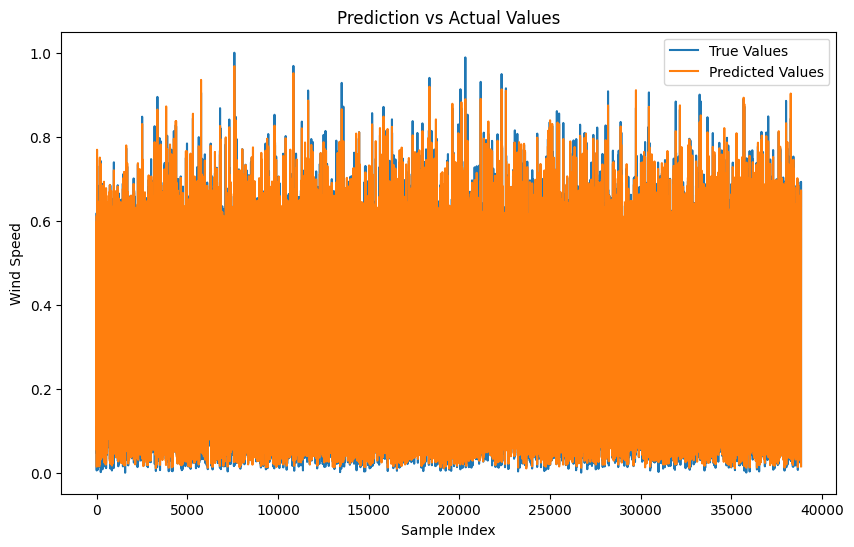

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_14672\881234559.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_14672\881234559.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637

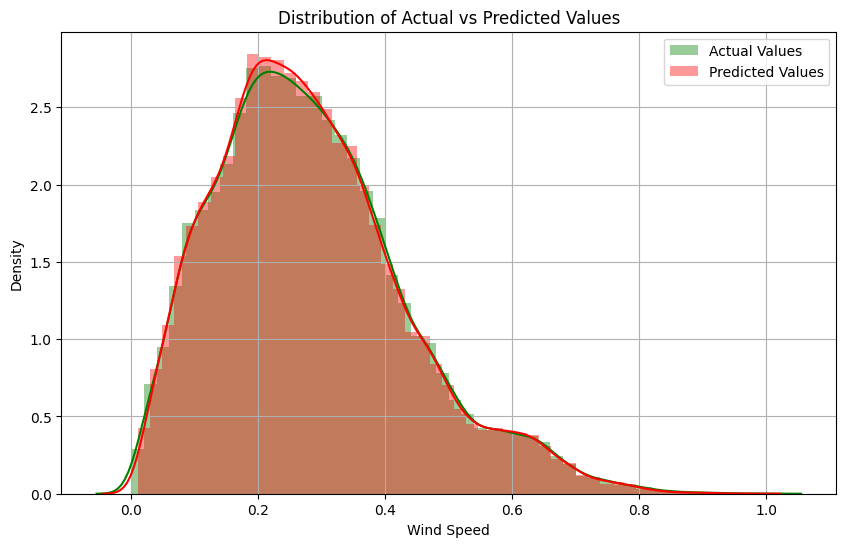

In [19]:
plt.figure(figsize=(10, 6))
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

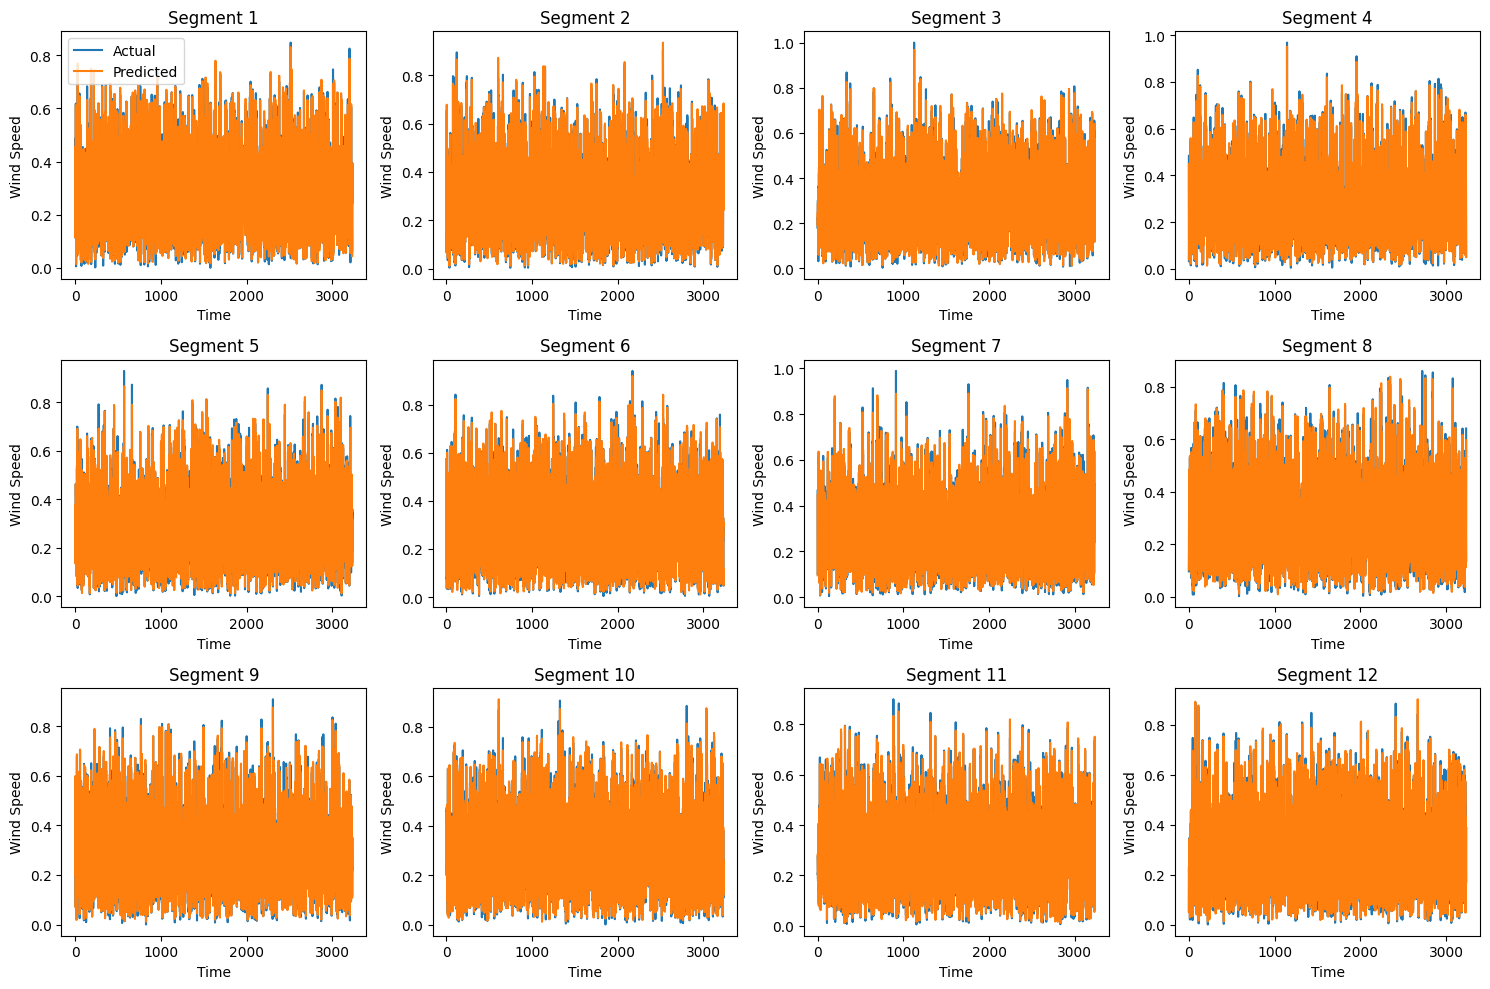

In [20]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(y_test)
points_per_plot = total_points // num_plots

plt.figure(figsize=(15, 10))  # Adjust the size as needed

for i in range(num_plots):
    plt.subplot(3, 4, i + 1)
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot
    plt.plot(y_test[start_idx:end_idx], label='Actual')
    plt.plot(y_pred[start_idx:end_idx], label='Predicted')
    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    if i == 0:  # Only add legend to the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

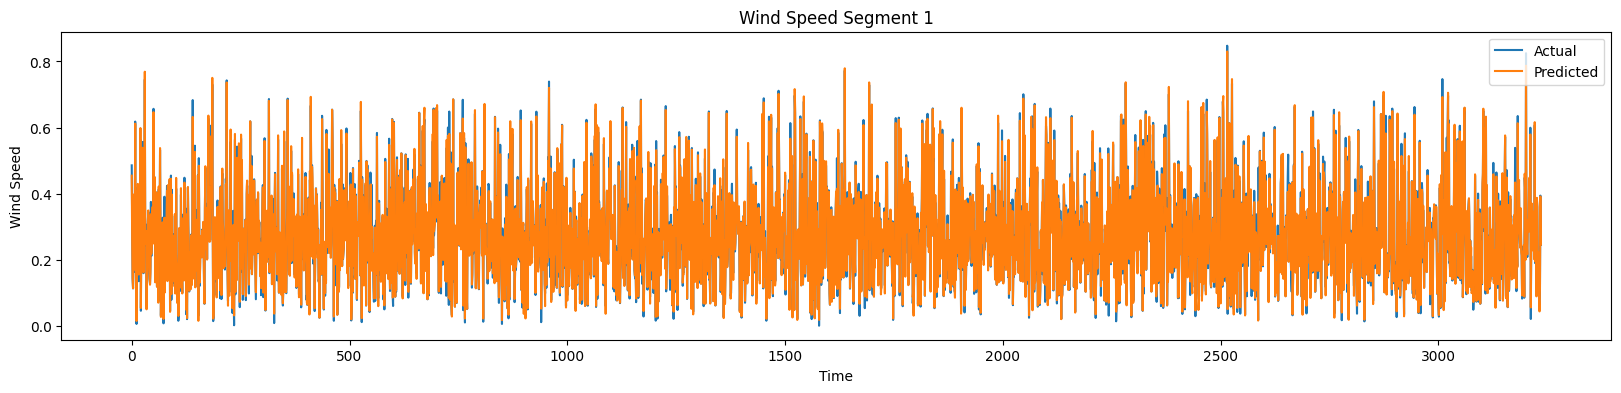

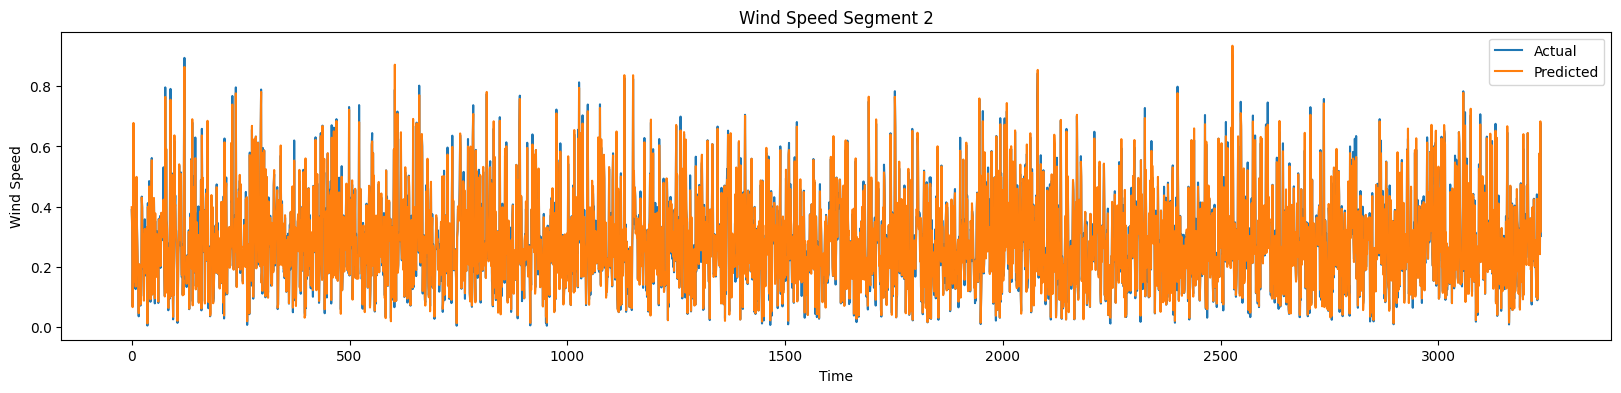

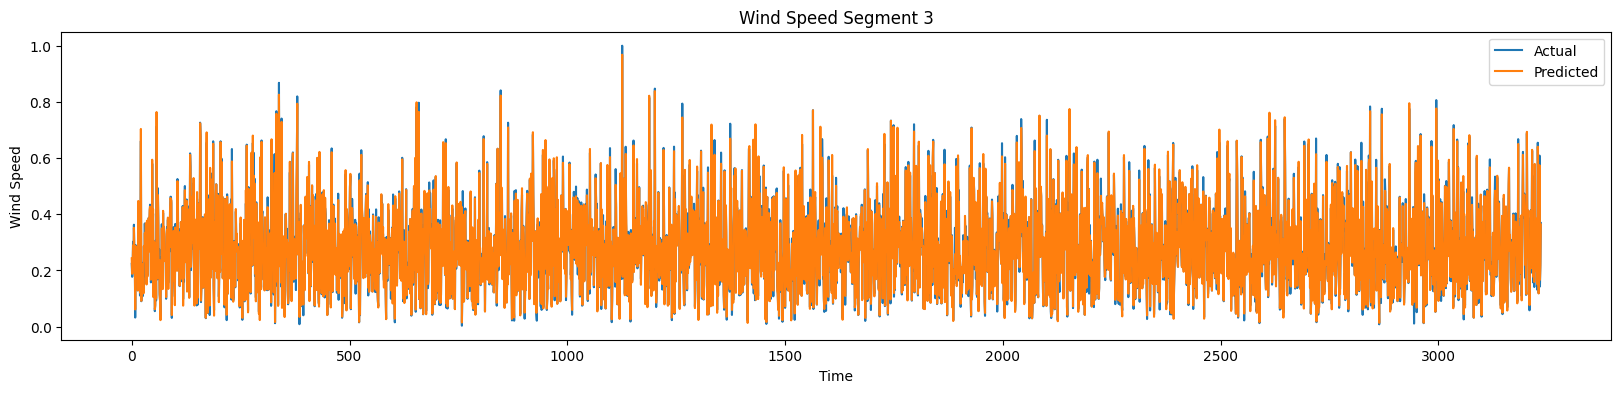

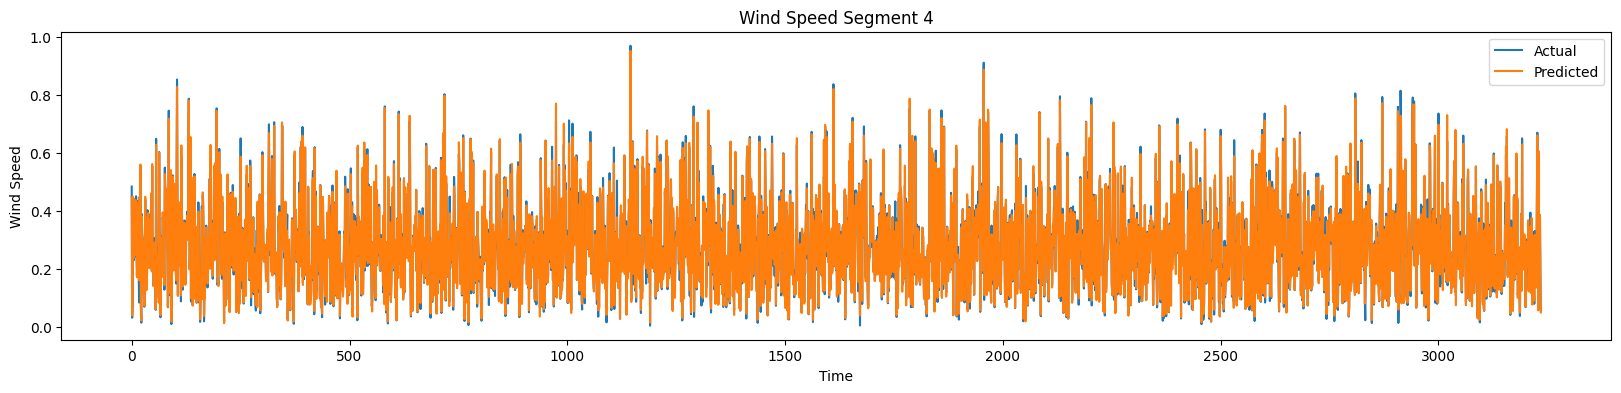

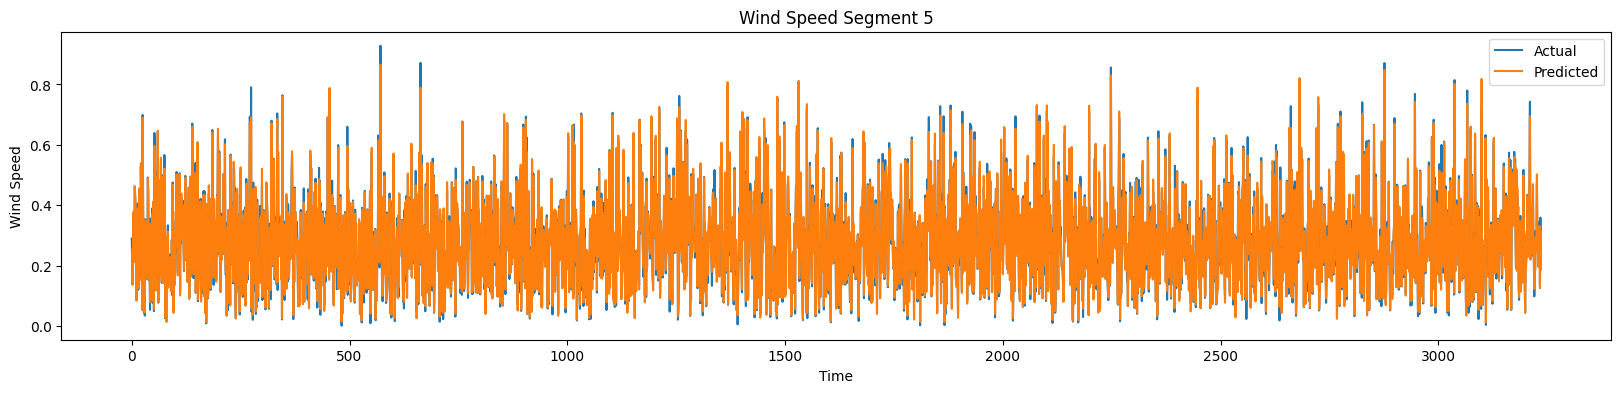

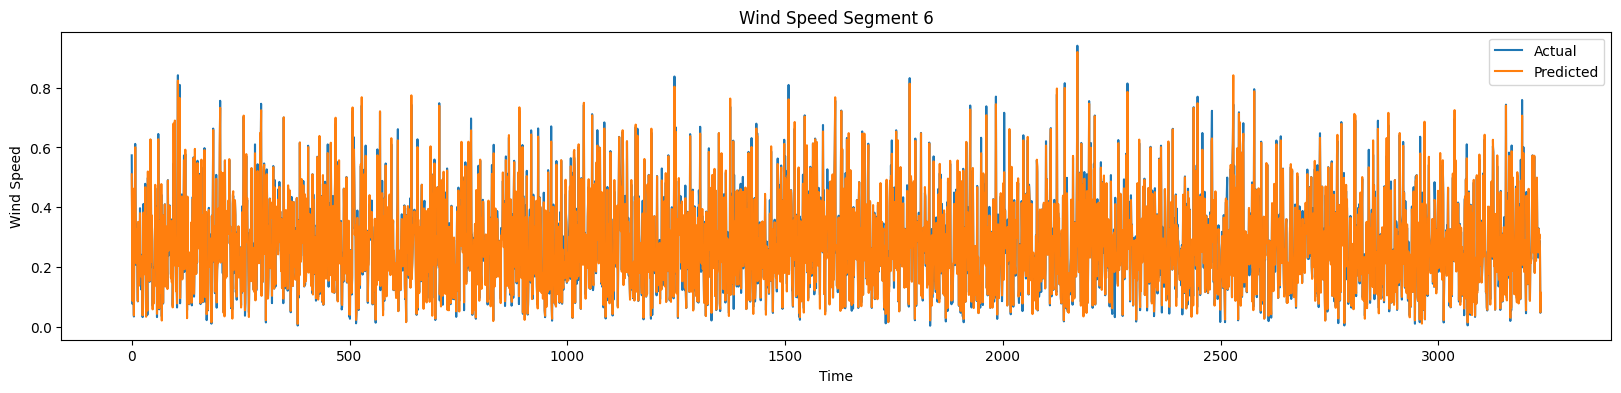

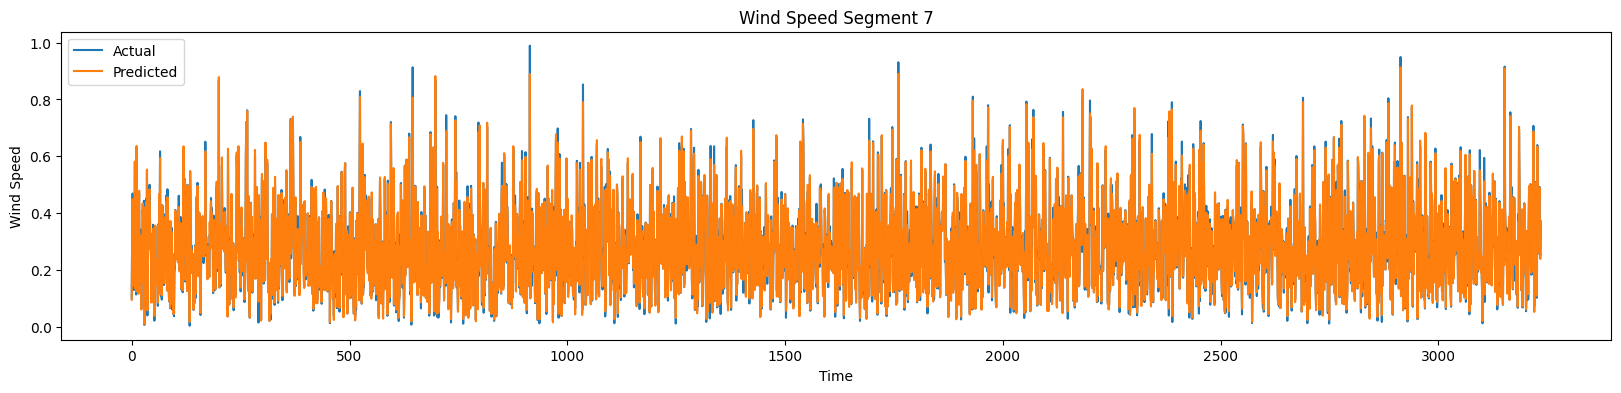

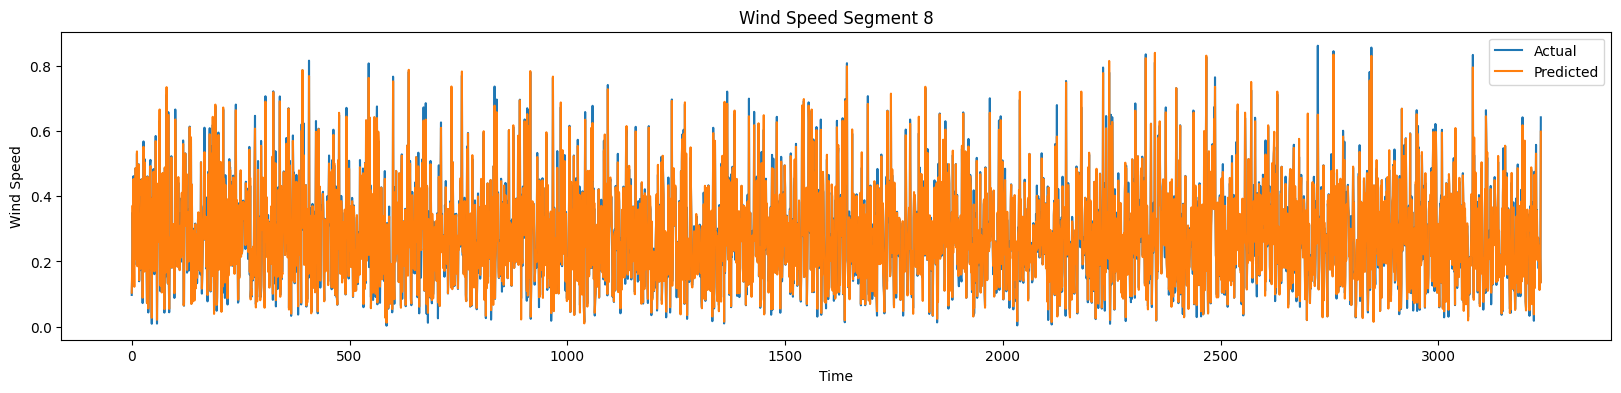

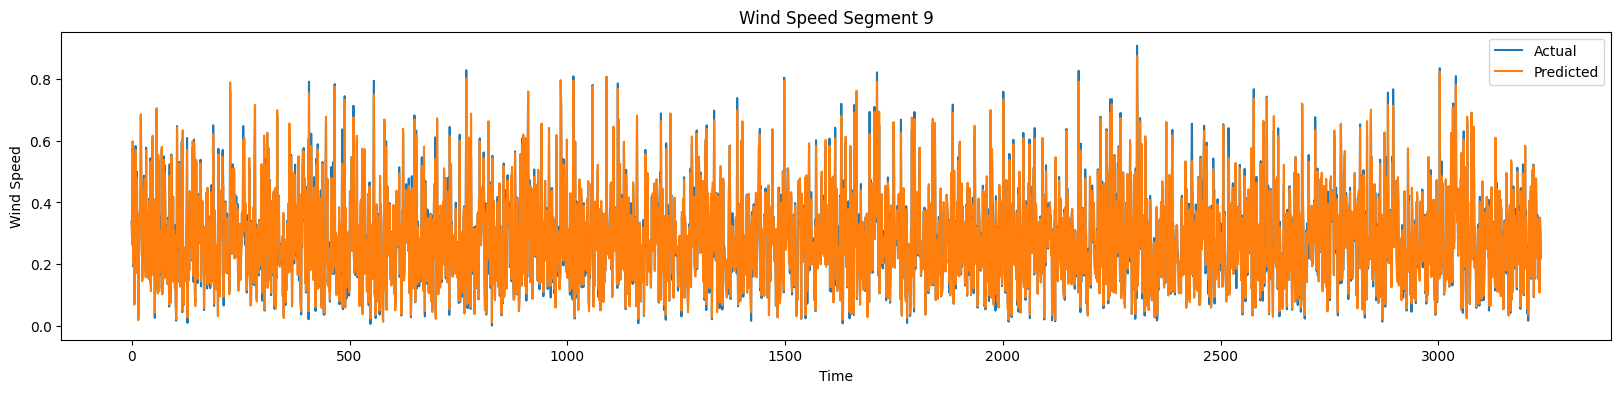

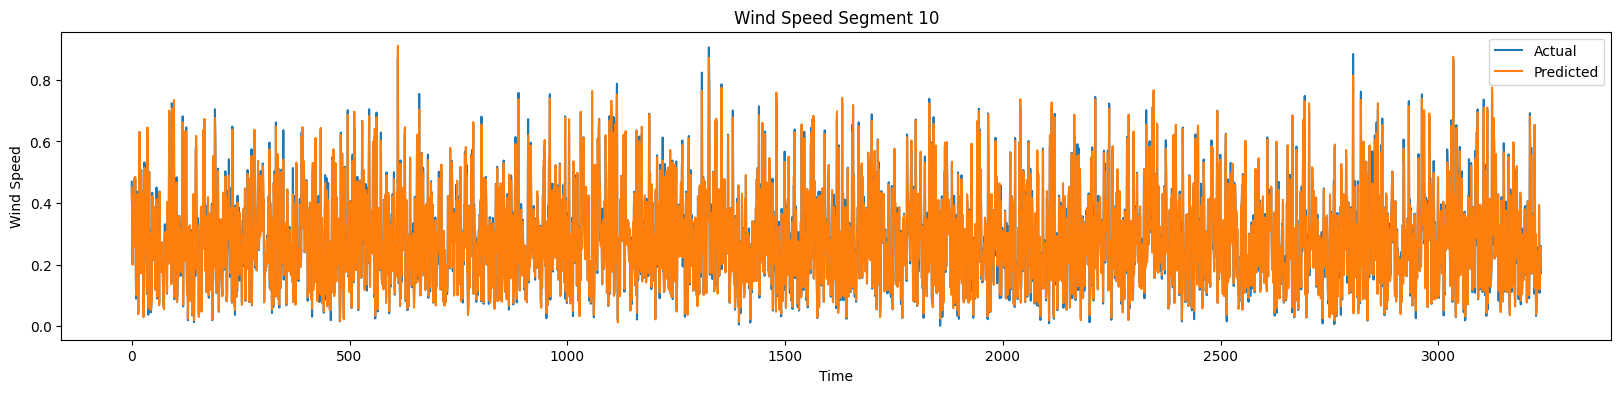

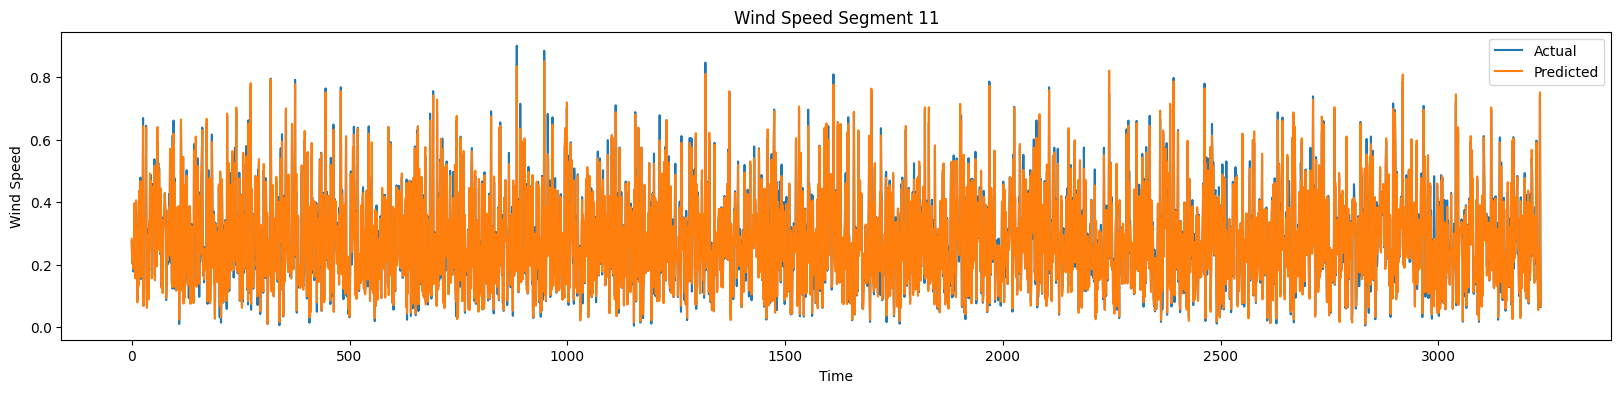

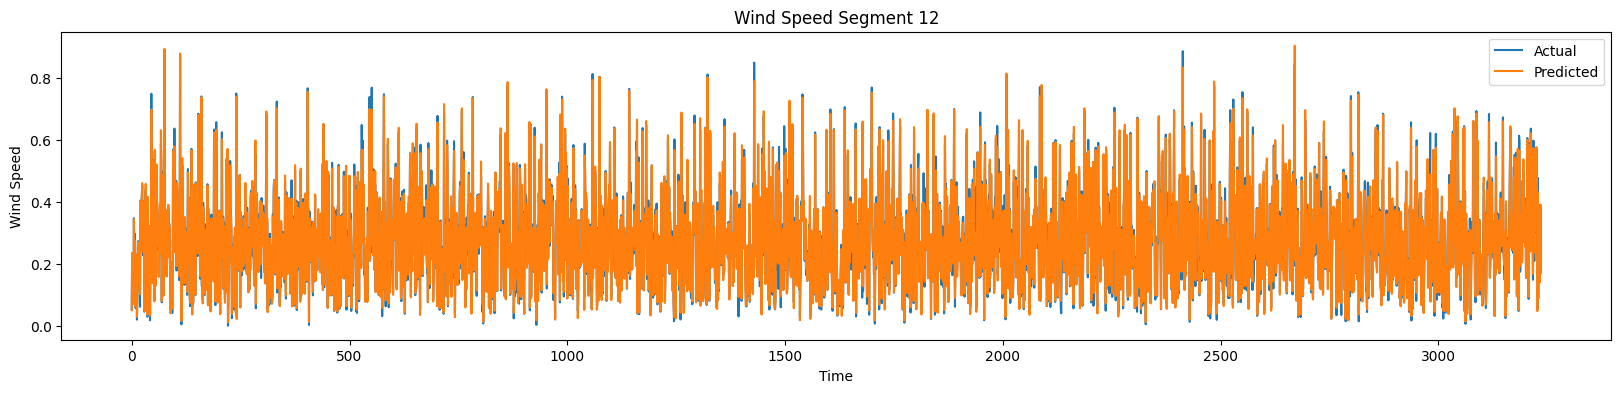

In [21]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(y_test)
points_per_plot = total_points // num_plots

for i in range(num_plots):
    plt.figure(figsize=(20, 4))  # Adjust the size as needed
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot

    plt.plot(y_test[start_idx:end_idx], label='Actual')
    plt.plot(y_pred[start_idx:end_idx], label='Predicted')
    plt.title(f'Wind Speed Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()

In [2]:
from netCDF4 import Dataset as netcdf 
import xarray as xr
import cftime
from geopy.geocoders import Nominatim

In [3]:
ds1 = xr.open_dataset('../Data/UK_Historical_Wind.nc')
print(ds1)

<xarray.Dataset>
Dimensions:    (time: 180, bnds: 2, lat: 20, lon: 15)
Coordinates:
  * time       (time) object 2000-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 50.28 50.83 51.39 51.94 ... 59.17 59.72 60.28 60.83
  * lon        (lon) float64 -10.42 -9.583 -8.75 -7.917 ... -0.4167 0.4167 1.25
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    sfcWind    (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-23T14:00:27Z
    ...                     ...
    tracking_id:            hdl:21.14100/4c6bedf9-19e9-4663-99bc-11e756840aa1
    variable_id:            sfcWind
    variable_name:          sfcWind


In [4]:
ncset1 = netcdf('../Data/UK_Historical_Wind.nc', mode='r')
ncset1.set_auto_mask(False)
lon1 = ncset1['lon'][:]
lat1 = ncset1['lat'][:]
t1 = ncset1['time'][:]
sfcWind = ncset1['sfcWind'][:]
nctime1 = ncset1.variables['time'][:]
t_unit1 = ncset1.variables['time'].units
ncset1.close()

try:
    t_cal1 = nctime1.calendar
except AttributeError:  # Attribute doesn't exist
    t_cal1 = u"360_day"  # or standard
datevar1 = cftime.num2date(nctime1, units=t_unit1, calendar=t_cal1)

[lons, lats] = np.meshgrid(lon1, lat1)

print(datevar1[0])
print(datevar1[100])
print(sfcWind.shape)

2000-01-16 00:00:00
2008-05-16 00:00:00
(180, 20, 15)


London, Greater London, England, United Kingdom
-0.1277653 51.5074456


Text(0.5, 1.0, 'Compare CMIP temperature prediction for London')

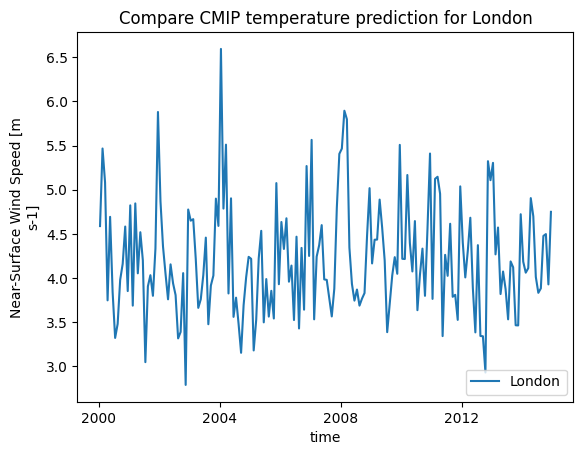

In [5]:
geolocator = Nominatim(user_agent="Google Geocoding API (V3)")
location = geolocator.geocode("London")
print(location.address)
print(geolocator.geocode("London").longitude,geolocator.geocode("London").latitude)

# Get coords of cities
lons1,lats1=geolocator.geocode("London").longitude,geolocator.geocode("London").latitude

ds1.sfcWind.sel(lon=lons1, lat=lats1, method = 'nearest').plot.line(x="time")

# Get data for coords

labels = ['London']

plt.legend(labels,loc='lower right')
plt.title('Compare CMIP temperature prediction for ' + labels[0])

In [80]:
# Extract data for London
london_data = ds1.sfcWind.sel(lon=lons1, lat=lats1, method='nearest').to_dataframe()

# Normalize the data
trimmed_london_data = london_data.iloc[:, -1].values
#trimmed_london_data_repeat = np.repeat(trimmed_london_data, 30)
trimmed_london_data_reshaped = trimmed_london_data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
london_data_scaled = scaler.fit_transform(trimmed_london_data_reshaped)
#trimmed_london_data_scaled = london_data_scaled[:, -1:]

# Convert to supervised learning structure
def create_dataset(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

time_steps = time_steps  # same as used in the model
london_data_supervised = create_dataset(pd.DataFrame(london_data_scaled), time_steps)

# Split the data
split_idx = int(0.075 * len(london_data_supervised))
london_data_train = london_data_supervised[:split_idx]
london_data_test = london_data_supervised[split_idx:]

In [81]:
london_data_train.shape

(12, 10, 1)

In [82]:
# Check the shape of data expected by the model
print("Expected input shape:", lstm_model.layers[0].input_shape)

# Check the shape of the data
print("Shape of London data:", london_data_test.shape)

Expected input shape: (None, 10, 1)
Shape of London data: (158, 10, 1)


In [83]:
london_pred = lstm_model.predict(london_data_train)

1/1 [==============================] - 0s 25ms/step


In [84]:
london_pred_inversed = scaler.inverse_transform(london_pred)

In [88]:
london_test_data = ds1.sfcWind.sel(lon=lons1, lat=lats1, method='nearest')

london_test_values = london_test_data.values

#london_pred_inversed.shape

#london_train_values = london_data_train.values

(12, 1)

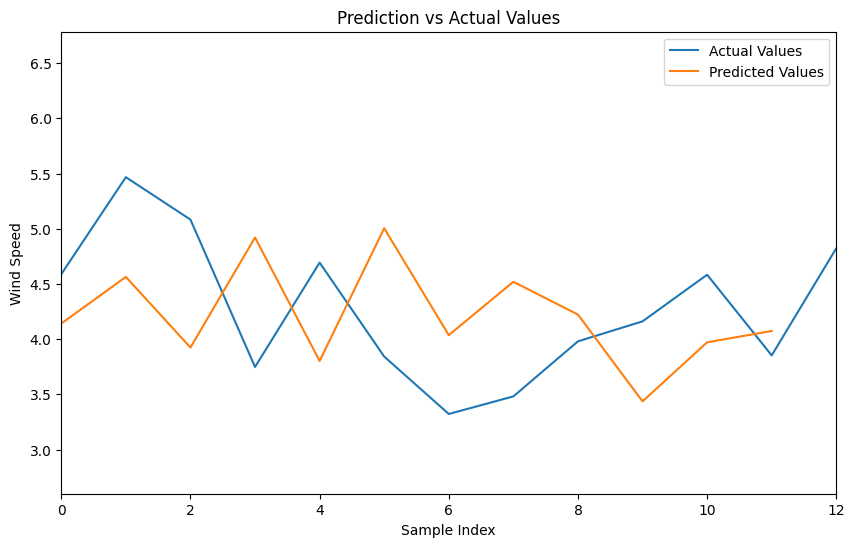

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(trimmed_london_data, label='Actual Values')
plt.plot(london_pred_inversed, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.xlim([0, london_pred_inversed.shape[0]])
plt.legend()
plt.show()

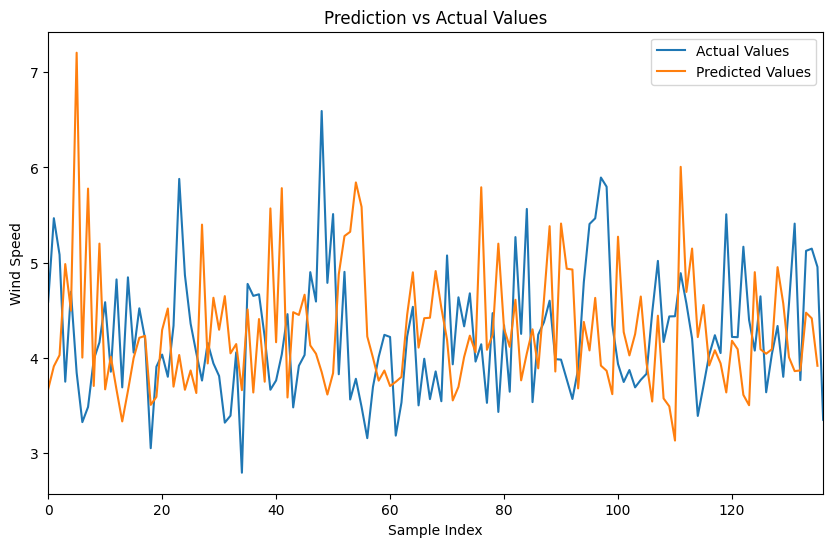

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(london_test_values, label='Actual Values')
plt.plot(london_pred_inversed, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.xlim([0, london_data_test.shape[0]])
plt.legend()
plt.show()

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_14672\2066396282.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_14672\2066396282.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

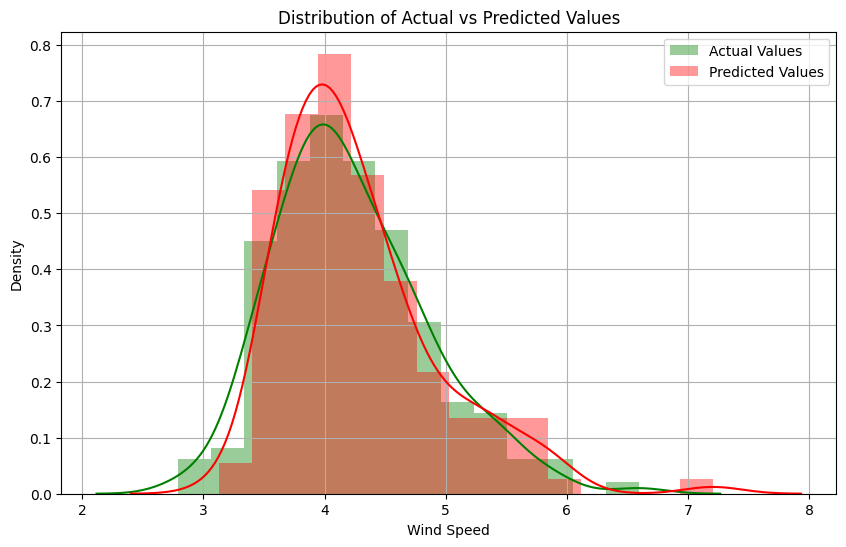

In [90]:
plt.figure(figsize=(10, 6))
y_test_flat = london_test_values.flatten()
y_pred_flat = london_pred_inversed.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

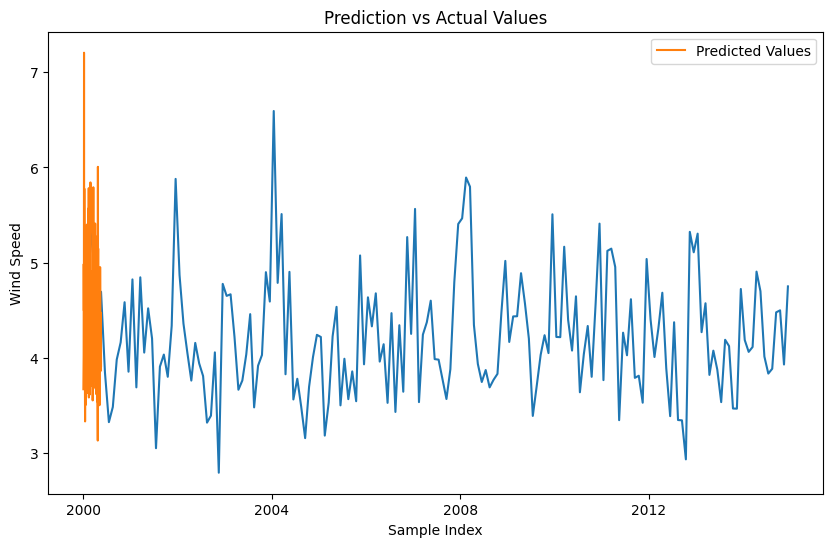

In [88]:
plt.figure(figsize=(10, 6))
ds1.sfcWind.sel(lon=lons1, lat=lats1, method = 'nearest').plot.line(x="time")
plt.plot(london_pred_inversed, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

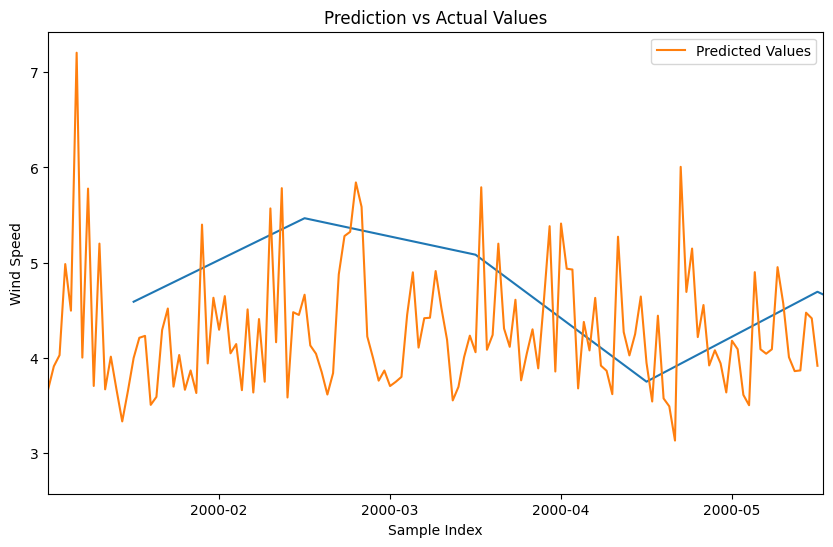

In [102]:
plt.figure(figsize=(10, 6))
ds1.sfcWind.sel(lon=lons1, lat=lats1, method = 'nearest').plot.line(x="time")
plt.plot(london_pred_inversed, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.xlim([0, london_data_test.shape[0]])
plt.legend()
plt.show()